## Import libraries

In [9]:
# Default libraries
import copy
import tqdm
import numpy as np
import scipy.signal as signal
import scipy.optimize as optimize
import matplotlib.pyplot as plt

# Custom libraries
import Functions.data_tools as data_tools
from Functions.temple_data import TempleData
from Functions.artifact_removal_tool import ART
from Functions import eeg_quality_index as eqi
from Functions import optimization as optimization

# Magic command to automatically reload modules
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import data

In [10]:
# List of files for the whole analysis
files = [
    r"Data\Temple\edf\01_tcp_ar\052\00005230\s002_2010_09_07\00005230_s002_t000.edf", 
    # r"Data\Temple\edf\01_tcp_ar\072\00007229\s001_2010_11_02\00007229_s001_t000.edf"
    # r"Data\Temple\edf\01_tcp_ar\052\00005230\s002_2010_09_07\00005230_s002_t000.edf",
]

## General Settings

In [11]:
# Settings
artifact_type = "eyem"
window_length = 2   # Window length for artifact [sec]
var_tol = 1e-15  # Threshold for variance tolerance (used in ART) | default=1e-15

# Optimization hyperparameters
n_clusters = (1, 10)
fd_threshold = (0.1, 10)
ssa_threshold = (0.001, 0.1)
bounds = (n_clusters, fd_threshold, ssa_threshold)

In [12]:
def simulated_annealing_optimizer(
    func,
    bounds,
    args,
    callback = lambda intermediate_result: None,
    display = True,
    max_iter = 100,
    max_stag_count = 20,
    x_err_tol = 0.1,
    MR = 0.5
    ):

    # Configurables
    max_stag_count = max_stag_count # maximum number of iterations where x_err hasn't changed
    max_iter = max_iter # maximum number of iterations
    x_err_tol = x_err_tol # tolerance for x_err (stop searching for a better solution when x_err < x_err_tol)
    MR = MR # mutation rate

    # Simulated annealing params
    T = 1
    alpha = 0.99
    beta = 1
    update_iters = 1

    def generate_candidate(bounds=bounds, args = args):
        x = [(np.random.uniform(bounds[d][0], bounds[d][1])) for d in range(len(bounds))]
        return x, func(x, *args)

    def generate_neighboring_candidate(x, MR=MR, bounds=bounds, args = args):
        x_new = copy.deepcopy(x)
        for i in range(len(x)):
            if np.random.uniform(0, 1) < MR:
                x_new[i] = np.random.uniform(bounds[i][0], bounds[i][1])
        return x_new, func(x_new, *args)

    x, x_err = generate_candidate(bounds, args) # generate a random x (particle/candidate) and its error (cost/objective/fitness function value)
    x_best = x.copy() # best solution found so far
    x_best_err = x_err # best error for that solution

    prev_x_err = x_err # previous iteration's x_err
    stag_count = 0 # number of iterations where x_err hasn't changed
    max_stag_count = max_stag_count # generate a new starting candidate if x_err hasn't changed for max_stag_count iterations

    # Stopping conditions
    max_iter = max_iter # maximum number of iterations
    x_err_tol = x_err_tol # stop searching for a better solution when x_err < x_err_tol

    pbar = tqdm() if display else None # progress bar
    n_iter = 1
    try:
        while (abs(x_best_err) > x_err_tol) and (n_iter < max_iter):
            
            if display:
                pbar.set_description(f'x_best_err: {x_best_err:.4f}')
                pbar.update(1)

            prev_x_err = x_err
            stag_count = stag_count + 1 if prev_x_err == x_err else 0

            x_new, x_new_err = generate_neighboring_candidate(
                x = x,
                MR = MR,
                bounds = bounds,
                args = args
                )

            if x_new_err <= x_err:
                x, x_err = x_new, x_new_err
                if x_err <= x_best_err:
                    x_best, x_best_err = x, x_err
            else:
                if np.random.uniform(0, 1) < np.exp(-beta * (x_new_err - x_err)/T):
                    x, x_err = x_new, x_new_err
                    
            if n_iter % update_iters == 0:
                T = alpha*T
                T = T if T > 0.01 else 0.01

            n_iter += 1

            callback((x_best, x_best_err))

    except KeyboardInterrupt:
        pass
    finally:
        pbar.close() if display else None

    print(f"x_best_err: {x_best_err:.4f} after {n_iter} iterations")

    return x_best, x_best_err

def heuristic_optimizer(
        func,
        bounds,
        args,
        callback = lambda intermediate_result: None,
        display = True,
        max_iter = 100,
        max_stag_count = 20,
        x_err_tol = 0.1,
        MR = 0.5
        ):

    # Configurables
    max_stag_count = max_stag_count # maximum number of iterations where x_err hasn't changed
    max_iter = max_iter # maximum number of iterations
    x_err_tol = x_err_tol # tolerance for x_err (stop searching for a better solution when x_err < x_err_tol)
    MR = MR # mutation rate

    def generate_candidate(bounds=bounds, args = args):
        x = [(np.random.uniform(bounds[d][0], bounds[d][1])) for d in range(len(bounds))]
        return x, func(x, *args)

    def generate_neighboring_candidate(x, MR=MR, bounds=bounds, args = args):
        x_new = copy.deepcopy(x)
        for i in range(len(x)):
            if np.random.uniform(0, 1) < MR:
                x_new[i] = np.random.uniform(bounds[i][0], bounds[i][1])
        return x_new, func(x_new, *args)

    x, x_err = generate_candidate(bounds, args) # generate a random x (particle/candidate) and its error (cost/objective/fitness function value)
    x_best = x.copy() # best solution found so far
    x_best_err = x_err # best error for that solution

    prev_x_err = x_err # previous iteration's x_err
    stag_count = 0 # number of iterations where x_err hasn't changed
    max_stag_count = max_stag_count # generate a new starting candidate if x_err hasn't changed for max_stag_count iterations

    # Stopping conditions
    max_iter = max_iter # maximum number of iterations
    x_err_tol = x_err_tol # stop searching for a better solution when x_err < x_err_tol

    pbar = tqdm() if display else None # progress bar
    n_iter = 1
    try:
        while abs(x_best_err) > x_err_tol and n_iter < max_iter:
            
            if display:
                pbar.set_description(f'x_best_err: {x_best_err:.4f}')
                pbar.update(1)

            prev_x_err = x_err
            stag_count = stag_count + 1 if prev_x_err == x_err else 0
            
            # Generate a random neighbor of x and calculate its error
            if stag_count > max_stag_count:
                x_new, x_new_err = generate_candidate(bounds, args)
                stag_count = 0
            else:
                x_new, x_new_err = copy.deepcopy(x), x_err
                x_new, x_new_err = generate_neighboring_candidate(x = x_new, MR = MR, bounds=bounds, args=args)

            # Update x and x_err if the new solution is better
            if x_new_err < x_err:
                x, x_err = x_new, x_new_err # if x_new is better, update x and x_err
                if x_err < x_best_err:
                    x_best, x_best_err = x, x_err # if x_new is the best, update x_best and x_best_err

            n_iter += 1

            callback((x_best, x_best_err))

    except KeyboardInterrupt:
        pass
    finally:
        pbar.close() if display else None

    print(f"x_best_err: {x_best_err:.4f} after {n_iter} iterations")

    return x_best, x_best_err

In [13]:
for file in files:
    # Import data file
    temple = TempleData(file)

    # Get artifact data
    artifacts_file = fr"Data\\Temple\\csv\\labels_{temple.montage_type}.csv"
    # artifacts_file = fr"/home/araz/Downloads/Araz/csv/labels_{temple.montage_type}.csv"
    temple.get_artifacts_from_csv(artifacts_file)

    [artifacts_chans, artifacts_data] = temple.get_artifact_type_data(
        artifact_type = artifact_type,
        window_length = window_length,
    )

    # Get clean data
    clean = temple.get_clean_data(window_length)
    clean_avg = signal.detrend(clean[10,:,:])

    # iteration_results = [None] * len(artifacts_chans)
    iteration_results = {}

    # Split list into optimization and testing artifacts
    [ioptimization, itest] = data_tools.split_list(
        lst = list(range(5)),
        test_percentage = 20,
        seed = 42
        )

    # Perform optimization per artifact
    for a, artifact in enumerate([artifacts_chans[i] for i in ioptimization]):
        
        iteration_results[a] = []
        temp_results = []

        # Get subset of channels based on artifact
        subset_chans = [temple.ch_names.index(chan) for chan in artifact if chan in temple.ch_names]

        # Constant arguments
        args = (
            clean_avg[subset_chans,:],
            signal.detrend(artifacts_data[a][:,:]), 
            temple.srate,
            window_length,
            var_tol
        )
        
        optimization_results = simulated_annealing_optimizer(
            func = optimization.maximize_eqi,
            bounds = bounds,
            args = args,
            display=False,
            # polish = True,
            callback = lambda intermediate_result: temp_results.append(intermediate_result),
            max_iter = 100,
            MR = 0.5
        )
        
        iteration_results[a] = temp_results

Extracting EDF parameters from c:\Users\danie\Documents\Projects\art-eqi-p300-validation\Data\Temple\edf\01_tcp_ar\052\00005230\s002_2010_09_07\00005230_s002_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
x_best_err: 94.7727 after 100 iterations
x_best_err: 86.3636 after 100 iterations
x_best_err: 93.8636 after 100 iterations
x_best_err: 91.1364 after 100 iterations


## Test optimization results

Use the optimizes hyper-parameters in the test trial.

IndexError: list index out of range

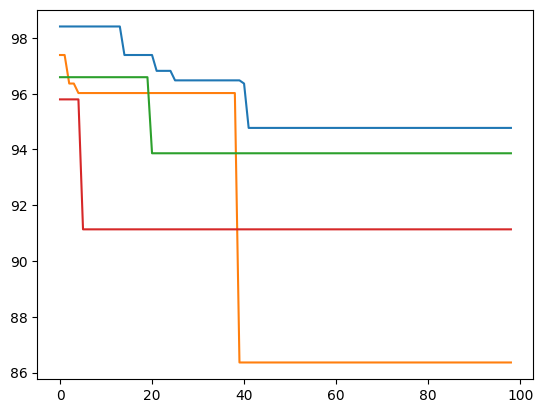

In [14]:
iteration_errs = []
for iteration_res in iteration_results:
    iteration_errs.append([res[1] for res in iteration_results[iteration_res]])

for i, artifact in enumerate(artifacts_chans[:-1]):
    plt.plot(iteration_errs[i], label = artifact)

plt.legend(
    bbox_to_anchor = (1.05, 1),
    loc = 'upper left',
    borderaxespad = 0
)
plt.title(f"{artifact_type} artifact")
plt.ylabel("Error")
plt.xlabel("Iteration")
plt.show()